# An Introduction to Co-Word Analysis

by James Gopsill

<hr>

Co-word analysis is the investigation of the semantic structure of a corpus of textual data through the co-occurrence of terms. By analysing the co-occurrence of terms, a network of connected terms is generated, which enables the application of algorithms developed in graph theory to uncover underlying structures (normally referred to as themes) and examine the nature of the connections behind the terms. For example, centrality measures are often used to identify the most important and influential terms within the network structure. In addition, clustering algorithms such as Louvain community partitioning are used to identify groups of highly connected terms within a network. A primary application of co-word analysis has been the identification of research themes and key terms within scientific communities ([Ding et al. 2001][1]; [Coulter et al.][2]; [Liu et al. 2014][3]).

This notebook provides a brief introduction and demmonstration of some of the techniques that are used in co-word analysis. Hopefully it will give you a good starting point as well as the confidence to try it out on your datasets. In this introduction, we will be applying co-word analysis on the keywords used by conference papers in [DESIGN 2012][4].

The analysis is broken down in 5 steps and covers:

* Importing the relevant python packages and data;
* Generating a co-word network of keywords;
* Visualising the co-word network;
* Clustering the co-word network; and,
* Identifying key terms within the network.

Before continuing, we need to import the relevant packages for our analysis.

[1]: http://www.sciencedirect.com/science/article/pii/S0306457300000510
[2]: http://onlinelibrary.wiley.com/doi/10.1002/(SICI)1097-4571(1998)49:13%3C1206::AID-ASI7%3E3.0.CO;2-F/epdf
[3]: http://delivery.acm.org/10.1145/2560000/2556969/p3553-liu.pdf?ip=137.222.114.243&id=2556969&acc=ACTIVE%20SERVICE&key=BF07A2EE685417C5%2E3DCFD3605FE4B4CE%2E4D4702B0C3E38B35%2E4D4702B0C3E38B35&CFID=638504200&CFTOKEN=96987752&__acm__=1467362675_d2665f24777acc735ff8e1e8f1bc2ab6
[4]: https://www.designsociety.org/publication/30980/ds_70_proceedings_of_design_2012_the_12th_international_design_conference_dubrovnik_croatia

In [18]:
# A line of code that jupyter notebook uses to plot the images inline with the code and text
%matplotlib inline
# Custom settings for the python notebook to save images as svg rather than png
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

# Packages we need for the analysis

import networkx as nx # Network creation, drawing and analysing package
import json # for reading json data
import matplotlib.pyplot as plt # for plotting networks diagrams
import matplotlib.patches as mpatches
import community # Louvain community clusering algorithm
import collections # Counting occurrences of items within lists
import operator # for sorting dictionary objects

## Importing the data into python

The publication data has been extracted from the book of abstracts and stored within a JSON file. The following code reads this data into a list of dictionaries in python.

In [19]:
# load the data from the file
with open('DESIGN2012.json', 'r', encoding='iso-8859-15') as f:
    data = f.read()

# read json object
data = json.loads(data)
papers = data['rows']
# pretty print an example data row
print(papers[0])

{'publication_title': 'THE UNDERLYING RELATIONSHIPS BETWEEN SUCCESS CRITERIA &amp; SUCCESS FACTORS IN NPD ACTIVITIES', 'publication_author': 'Achiche S., Howard T. J., McAloone T. C., Deng L., Baron L.', 'publication_keyword': 'new product development, success criteria and factors, project management', 'publication_conf_code': 'DESIGN 2012'}


## Extracting the keywords and counting their occurrences

Now that we have the data loaded into python, we can form a list of keywords and count how many times they have been used across the papers. This code loops through all the papers and extracts the keywords from each paper. The keywords are comma separated and all letters placed in lowercase to help the matching of keywords.

This forms a list containing all the keywords used in the conference including duplicates as some papers may have used the same keywords (and this is what we're looking for). Using the collections package enables us to find all the unique keywords and the number of times they appear within the list.

Figure 1 shows the number of times the keyowrds of occurred within the DESIGN 2012 conference (ordered by number of occurrences).

In [20]:
keyword_list = [] # empty list
for paper in papers:
    keywords = paper['publication_keyword'].lower().split(',') # splitting keywords
    keywords = [x.strip() for x in keywords] # stripping whitespace
    keyword_list.extend(keywords) # add keywords to list
    
print('Number of Keywords:', len(keyword_list))
keyword_list = collections.Counter(keyword_list).most_common() # count the number of re-occurrences of keywords
print(keyword_list[0:10])

# create list of appearence for plotting
y = [k[1] for k in keyword_list]

Number of Keywords: 843
[('design process', 10), ('product development', 7), ('knowledge management', 7), ('design methods', 7), ('product development process', 6), ('innovation', 5), ('product-service systems', 5), ('uncertainty', 5), ('cad', 5), ('creativity', 5)]


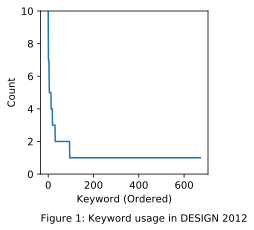

In [21]:
# plotting the number of occurrences each keyword has had
plt.figure(figsize=(3, 3))
plt.plot(y)
plt.ylim(0, 10)
plt.xlabel('Keyword (Ordered)')
plt.ylabel('Count')
plt.annotate('Figure 1: Keyword usage in DESIGN 2012', (0,0), (0, -40), xycoords='axes fraction', textcoords='offset points', va='top')
plt.show()

## Creating the Nodes

We shall now use this keyword list to generate the nodes of the network using the NetworkX package. We also create a new list that contains the unique keywords produced by collections.Counter. In addition, the frequency relates to the number of occurrences of that keyword.

In [22]:

# Generate Graph
g = nx.Graph()

# Get the keywords of interest
graph_keywords = []
for i, keyword in enumerate(keyword_list):
    graph_keywords.append(keyword[0])
    g.add_node(i,
               keyword=keyword[0],
               freq=keyword[1]
              )

print('Number of Nodes in Network:', g.number_of_nodes())
        

Number of Nodes in Network: 673


## Creating the Edges (Co-occurrence of words)

No we have a network of nodes that are not connected. This stage takes each paper and links to keywords from that paper together. The loop also checks if an edge is present between the two nodes. If there is a connection then the weighting of that edge is increased by one. If not, a new edge is created linking the two keywords.

In [23]:
# for each paper in the conference
for paper in papers:
    # get the list of keywords from the paper
    keywords = paper['publication_keyword'].lower().split(',')
    keywords = [x.strip() for x in keywords]
    
    # loop through the keywords
    for i in range(0, len(keywords)-1):
        for j in range(i+1, len(keywords)):
            # get the indexes of the keywords so we can find them in the network
            keyword_one_idx = graph_keywords.index(keywords[i])
            keyword_two_idx = graph_keywords.index(keywords[j])
            
            # Check if the network has an edge.
            if g.has_edge(keyword_one_idx, keyword_two_idx):
                g[keyword_one_idx][keyword_two_idx]['weight'] = g[keyword_one_idx][keyword_two_idx]['weight'] + 1
            else:
                g.add_edge(keyword_one_idx, keyword_two_idx, weight=1)

print('Number of Edges in Network:', g.number_of_edges())

Number of Edges in Network: 1399


## Initial Network

The code below plots the initial network that has been created (Figure 2). It can be seen that there are a number of connected nodes that lie outside the main network structure (known as components). These are keywords that have been used by very few papers and thus, do not really tell us about the key themes within the conference. Although, the level of disconnection could give us an insight onto the broadness of topics being discissed at the conference and may reflect a lack of a common language and set of definitions within the community.

Number of Connected Components: 62


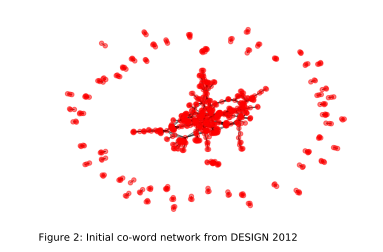

In [24]:
print('Number of Connected Components:', nx.number_connected_components(g))
pos = nx.spring_layout(g)
nx.draw_networkx(g, 
                 node_size=20,
                 alpha=0.5,
                 with_labels=False,
                 pos=pos)

plt.axis('off')
plt.annotate('Figure 2: Initial co-word network from DESIGN 2012', (0,0), (0, -5), xycoords='axes fraction', textcoords='offset points', va='top')
plt.show()

## Network Pruning

In order to remove these external components and nodes that are really used, a step known as 'pruning' occurs. This is where nodes are removed based on their characteristics within the network. This could be the frequency of their appearence and/or number of connections they have with the rest of the network for example. In this example, a node frequency of one has been used as the criteria for removing the node from the network. The removal also removes the edges associated with that node.

In [25]:
print('- Before Pruning -')
print('Number of Nodes in Network:', g.number_of_nodes())
print('Number of Edges in Network:', g.number_of_edges())

pruned_g = g.copy()
for n, d in g.nodes(data=True):
    if d['freq'] == 1:
        pruned_g.remove_node(n)
        
print('- After Pruning -')
print('Number of Nodes in Network:', pruned_g.number_of_nodes())
print('Number of Edges in Network:', pruned_g.number_of_edges())

- Before Pruning -
Number of Nodes in Network: 673
Number of Edges in Network: 1399
- After Pruning -
Number of Nodes in Network: 95
Number of Edges in Network: 134


## Graph Drawing

Figure 3 below shows the resulting network after the low frequency nodes have been removed. It can be seen that a large number of the components have removed although a few do remain. This may highlight some specialist or emerging themes of work, which has yet to find its place within the core research themes of the conference.

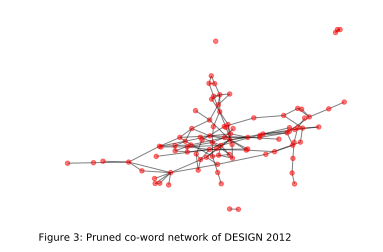

In [26]:
nx.draw_networkx(pruned_g, 
                 node_size=20,
                 alpha=0.5,
                 with_labels=False,
                 pos=pos)

plt.axis('off')
plt.annotate('Figure 3: Pruned co-word network of DESIGN 2012', (0,0), (0, -5), xycoords='axes fraction', textcoords='offset points', va='top')
plt.show()

## Applying Louvain Community Detection

Now that we have the pruned network that only contains the keywords that have been used by the majority of the conference papers, we can start to investigate the underlying structure of the network. One method of doing this is through clustering. In this example, we have applied the [Louvain Community detection algorithm](http://perso.crans.org/aynaud/communities/) to identify highly linked keywords ([Blondel et al., 2008](http://arxiv.org/pdf/0803.0476.pdf); [Wiki](https://en.wikipedia.org/wiki/Louvain_Modularity)).

The Louvain community algorithms' objective is to generate a set of clusters for the matrix that returns the highest modularity value. Modularity ($Q$) is an assessment of the quality of the matrix partition and is defined as [Newman (2004)](http://arxiv.org/pdf/cond-mat/0407503v1.pdf):


$$ Q = \frac{1}{2m}\sum_{ij}\bigg[A_{ij}-\frac{k_ik_j}{2m}\bigg]\delta(c_i,c_j) $$

Where $ m = \frac{1}{2}\sum_{ij}A_{ij} $ and is the number of co-occurrences within the matrix. $\delta$ is the Kronecker delta function and is 1 if a co-occurrence exists between two models and 0 otherwise. $ \frac{k_ik_j}{2m} $ is the probability that a co-occurrence may exist between two models, where $ k_i $ is the number of models that have co-occurrences with model $i$ and $ k_j $ is the number of models that have co-occurrences with model $j$. And, $A_{ij}$ is the weighted co-occurrence between two models in the matrix.

In order to obtain the highest modularity clustering, the algorithm iterates between two steps. The first assigns each model to its own cluster. This is then followed by the algorithm sequentially moving one model to a different cluster and calculating the change in modularity. From this, the maximum modularity change can be identified.

The second step merges the models together to form a cluster of models and combines the co-occurrences of model activity to form single co-occurrence links to the rest of the matrix and self-loops are used to identify internal co-occurrences between the models within the partition. The aim is to achieve a partitioning whereby each partition is highly connected internally and weakly connected to one another.

In this example, 12 clusters have been identified by the algorithm and the network drawn in Figure 4 has the nodes colour coded relation to these clusters.

Number of Clusters: 13


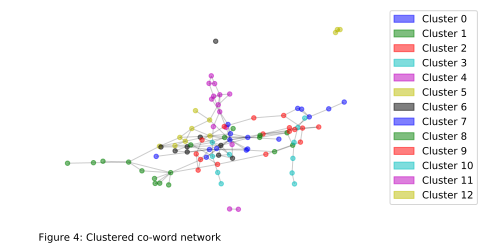

In [31]:
# run the louvain community detection algorithm (returns a dictionary odered by cluster number)
partition = best_partition(pruned_g)

# generate a set of colors for matplotlib
colors = "bgrcmykbgrcmykbgrcmykbgrcmyk"

number_of_partitions = 0
for idx in partition: # iterate throught the dictionary
    if partition[idx] > number_of_partitions:
        # if a new cluster then increment the cluster
        number_of_partitions = partition[idx]
            
    # draw the node and associated color
    nx.draw_networkx_nodes(pruned_g, 
                           nodelist=[idx], 
                           node_color=colors[partition[idx]],
                           node_size=20,
                           alpha=0.5,
                           pos=pos
                          )
    
# draw the edges
nx.draw_networkx_edges(pruned_g,
                       alpha=0.2,
                       pos=pos
                      )

print('Number of Clusters:', number_of_partitions)
legend_patches = []
for i in range(0, number_of_partitions):
    legend_patches.append( mpatches.Patch(color=colors[i], alpha=0.5, label='Cluster '+str(i)) )

plt.legend(handles=legend_patches, fontsize=10, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.annotate('Figure 4: Clustered co-word network', (0,0), (0, -5), xycoords='axes fraction', textcoords='offset points', va='top')
plt.axis('off')
plt.show()

## List nodes in a Cluster

Once we have the clusters, we can go one further and pull out the keywords that form the clusters. The code below shows and example of the keywords within cluster 10.

In [ ]:
cluster_number = 10

keywords = []
print('Cluster:', cluster_number)
for idx in partition:
    if partition[idx] == cluster_number:
        print(g.node[idx]['keyword'])

## Using Betweeness Centrality to Idenitfy Key Terms

In addition to clustering, we can analyse the nodes on the basis of how important they are in defining the structure of the network and the level of connectedness. This is often achieved through centrality measures and there are a number of different centrality measures that one can use. In this example, we are using the [Betweenness Centrality][1] measure, which counts the number of times a node is on the shortest paths between nodes in the network. This is defined mathematically as:

$$ c_B(v) = \sum_{s \neq v \neq t \in V}\frac{\sigma_{(s,t)}(v)}{\sigma_{(s,t)}} $$

where $\sigma_{(s,t)}$ is the total number of shortest paths from node $s$ to $t$ and $\sigma_{(s,t)}(v)$ is the number of paths through $v$.

For the DESIGN 2012 conference, it can be seen that Design Process, Product Development and Knowledge Management were the most central keywords within the conference. 

[1]: (https://en.wikipedia.org/wiki/Centrality)
[2]: (https://networkx.github.io/documentation/development/reference/generated/networkx.algorithms.centrality.betweenness_centrality.html#networkx.algorithms.centrality.betweenness_centrality)



In [ ]:
centralities = nx.betweenness_centrality(g)

sorted_centralities = sorted(centralities.items(), key=operator.itemgetter(1), reverse=True)
print(sorted_centralities[0:5])

print(g.node[sorted_centralities[0][0]])
print(g.node[sorted_centralities[1][0]])
print(g.node[sorted_centralities[2][0]])


## References & Additional Reading

I hope that this brief introduction to co-word analysis has helped and inspired you to try it out on your datasets.

[Vincent D Blondel, Jean-Loup Guillaume, Renaud Lambiotte, and Etienne Lefebvre. Fast unfolding of communities in large networks. Journal of Statistical Mechanics: Theory and Experiment, 2008(10):P10008, 2008.](http://arxiv.org/pdf/0803.0476.pdf)

[Mark EJ Newman. Analysis of weighted networks. Physical Review E, 70(5):056131, 2004.](http://arxiv.org/pdf/cond-mat/0407503v1.pdf)

[M. E. J. Newman. Modularity and community structure in networks. Proceedings of the National Academy of Sciences, 103(23):8577{8582, 2006. doi: 10.1073/pnas.0601602103.](http://www.pnas.org/content/103/23/8577.full.pdf)

[Wikipedia - Centrality](https://en.wikipedia.org/wiki/Centrality)

[Wikipedia - Louvain Modularity](https://en.wikipedia.org/wiki/Louvain_Modularity)

[Wikipedia - Modularity (Networks)](https://en.wikipedia.org/wiki/Modularity_(networks))


In [30]:
"""
This module implements community detection.
"""
from __future__ import print_function
__all__ = ["partition_at_level", "modularity", "best_partition", "generate_dendrogram", "generate_dendogram", "induced_graph"]
__author__ = """Thomas Aynaud (thomas.aynaud@lip6.fr)"""
#    Copyright (C) 2009 by
#    Thomas Aynaud <thomas.aynaud@lip6.fr>
#    All rights reserved.
#    BSD license.

__PASS_MAX = -1
__MIN = 0.0000001

import networkx as nx
import sys
import types
import array


def partition_at_level(dendrogram, level) :
    """Return the partition of the nodes at the given level

    A dendrogram is a tree and each level is a partition of the graph nodes.
    Level 0 is the first partition, which contains the smallest communities, and the best is len(dendrogram) - 1.
    The higher the level is, the bigger are the communities

    Parameters
    ----------
    dendrogram : list of dict
       a list of partitions, ie dictionnaries where keys of the i+1 are the values of the i.
    level : int
       the level which belongs to [0..len(dendrogram)-1]

    Returns
    -------
    partition : dictionnary
       A dictionary where keys are the nodes and the values are the set it belongs to

    Raises
    ------
    KeyError
       If the dendrogram is not well formed or the level is too high

    See Also
    --------
    best_partition which directly combines partition_at_level and generate_dendrogram to obtain the partition of highest modularity

    Examples
    --------
    >>> G=nx.erdos_renyi_graph(100, 0.01)
    >>> dendo = generate_dendrogram(G)
    >>> for level in range(len(dendo) - 1) :
    >>>     print "partition at level", level, "is", partition_at_level(dendo, level)
    """
    partition = dendrogram[0].copy()
    for index in range(1, level + 1) :
        for node, community in partition.items() :
            partition[node] = dendrogram[index][community]
    return partition


def modularity(partition, graph) :
    """Compute the modularity of a partition of a graph

    Parameters
    ----------
    partition : dict
       the partition of the nodes, i.e a dictionary where keys are their nodes and values the communities
    graph : networkx.Graph
       the networkx graph which is decomposed

    Returns
    -------
    modularity : float
       The modularity

    Raises
    ------
    KeyError
       If the partition is not a partition of all graph nodes
    ValueError
        If the graph has no link
    TypeError
        If graph is not a networkx.Graph

    References
    ----------
    .. 1. Newman, M.E.J. & Girvan, M. Finding and evaluating community structure in networks. Physical Review E 69, 26113(2004).

    Examples
    --------
    >>> G=nx.erdos_renyi_graph(100, 0.01)
    >>> part = best_partition(G)
    >>> modularity(part, G)
    """
    if type(graph) != nx.Graph :
        raise TypeError("Bad graph type, use only non directed graph")

    inc = dict([])
    deg = dict([])
    links = graph.size(weight='weight')
    if links == 0 :
        raise ValueError("A graph without link has an undefined modularity")

    for node in graph :
        com = partition[node]
        deg[com] = deg.get(com, 0.) + graph.degree(node, weight = 'weight')
        for neighbor, datas in graph[node].items() :
            weight = datas.get("weight", 1)
            if partition[neighbor] == com :
                if neighbor == node :
                    inc[com] = inc.get(com, 0.) + float(weight)
                else :
                    inc[com] = inc.get(com, 0.) + float(weight) / 2.

    res = 0.
    for com in set(partition.values()) :
        res += (inc.get(com, 0.) / links) - (deg.get(com, 0.) / (2.*links))**2
    return res


def best_partition(graph, partition = None) :
    """Compute the partition of the graph nodes which maximises the modularity
    (or try..) using the Louvain heuristices

    This is the partition of highest modularity, i.e. the highest partition of the dendrogram
    generated by the Louvain algorithm.

    Parameters
    ----------
    graph : networkx.Graph
       the networkx graph which is decomposed
    partition : dict, optionnal
       the algorithm will start using this partition of the nodes. It's a dictionary where keys are their nodes and values the communities

    Returns
    -------
    partition : dictionnary
       The partition, with communities numbered from 0 to number of communities

    Raises
    ------
    NetworkXError
       If the graph is not Eulerian.

    See Also
    --------
    generate_dendrogram to obtain all the decompositions levels

    Notes
    -----
    Uses Louvain algorithm

    References
    ----------
    .. 1. Blondel, V.D. et al. Fast unfolding of communities in large networks. J. Stat. Mech 10008, 1-12(2008).

    Examples
    --------
    >>>  #Basic usage
    >>> G=nx.erdos_renyi_graph(100, 0.01)
    >>> part = best_partition(G)

    >>> #other example to display a graph with its community :
    >>> #better with karate_graph() as defined in networkx examples
    >>> #erdos renyi don't have true community structure
    >>> G = nx.erdos_renyi_graph(30, 0.05)
    >>> #first compute the best partition
    >>> partition = community.best_partition(G)
    >>>  #drawing
    >>> size = float(len(set(partition.values())))
    >>> pos = nx.spring_layout(G)
    >>> count = 0.
    >>> for com in set(partition.values()) :
    >>>     count = count + 1.
    >>>     list_nodes = [nodes for nodes in partition.keys()
    >>>                                 if partition[nodes] == com]
    >>>     nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 20,
                                    node_color = str(count / size))
    >>> nx.draw_networkx_edges(G,pos, alpha=0.5)
    >>> plt.show()
    """
    dendo = generate_dendrogram(graph, partition)
    return partition_at_level(dendo, len(dendo) - 1 )


def generate_dendogram(graph, part_init = None) :
    """Deprecated, use generate_dendrogram"""
    return generate_dendrogram(graph, part_init)
    
    
def generate_dendrogram(graph, part_init = None) :
    """Find communities in the graph and return the associated dendrogram

    A dendrogram is a tree and each level is a partition of the graph nodes.  Level 0 is the first partition, which contains the smallest communities, and the best is len(dendrogram) - 1. The higher the level is, the bigger are the communities


    Parameters
    ----------
    graph : networkx.Graph
        the networkx graph which will be decomposed
    part_init : dict, optionnal
        the algorithm will start using this partition of the nodes. It's a dictionary where keys are their nodes and values the communities

    Returns
    -------
    dendrogram : list of dictionaries
        a list of partitions, ie dictionnaries where keys of the i+1 are the values of the i. and where keys of the first are the nodes of graph

    Raises
    ------
    TypeError
        If the graph is not a networkx.Graph

    See Also
    --------
    best_partition

    Notes
    -----
    Uses Louvain algorithm

    References
    ----------
    .. 1. Blondel, V.D. et al. Fast unfolding of communities in large networks. J. Stat. Mech 10008, 1-12(2008).

    Examples
    --------
    >>> G=nx.erdos_renyi_graph(100, 0.01)
    >>> dendo = generate_dendrogram(G)
    >>> for level in range(len(dendo) - 1) :
    >>>     print "partition at level", level, "is", partition_at_level(dendo, level)
    """
    if type(graph) != nx.Graph :
        raise TypeError("Bad graph type, use only non directed graph")

    #special case, when there is no link
    #the best partition is everyone in its community
    if graph.number_of_edges() == 0 :
        part = dict([])
        for node in graph.nodes() :
            part[node] = node
        return part

    current_graph = graph.copy()
    status = Status()
    status.init(current_graph, part_init)
    mod = __modularity(status)
    status_list = list()
    __one_level(current_graph, status)
    new_mod = __modularity(status)
    partition = __renumber(status.node2com)
    status_list.append(partition)
    mod = new_mod
    current_graph = induced_graph(partition, current_graph)
    status.init(current_graph)

    while True :
        __one_level(current_graph, status)
        new_mod = __modularity(status)
        if new_mod - mod < __MIN :
            break
        partition = __renumber(status.node2com)
        status_list.append(partition)
        mod = new_mod
        current_graph = induced_graph(partition, current_graph)
        status.init(current_graph)
    return status_list[:]


def induced_graph(partition, graph) :
    """Produce the graph where nodes are the communities

    there is a link of weight w between communities if the sum of the weights of the links between their elements is w

    Parameters
    ----------
    partition : dict
       a dictionary where keys are graph nodes and  values the part the node belongs to
    graph : networkx.Graph
        the initial graph

    Returns
    -------
    g : networkx.Graph
       a networkx graph where nodes are the parts

    Examples
    --------
    >>> n = 5
    >>> g = nx.complete_graph(2*n)
    >>> part = dict([])
    >>> for node in g.nodes() :
    >>>     part[node] = node % 2
    >>> ind = induced_graph(part, g)
    >>> goal = nx.Graph()
    >>> goal.add_weighted_edges_from([(0,1,n*n),(0,0,n*(n-1)/2), (1, 1, n*(n-1)/2)])
    >>> nx.is_isomorphic(int, goal)
    True
    """
    ret = nx.Graph()
    ret.add_nodes_from(partition.values())

    for node1, node2, datas in graph.edges(data = True) :
        weight = datas.get("weight", 1)
        com1 = partition[node1]
        com2 = partition[node2]
        w_prec = ret.get_edge_data(com1, com2, {"weight":0}).get("weight", 1)
        ret.add_edge(com1, com2, weight = w_prec + weight)

    return ret


def __renumber(dictionary) :
    """Renumber the values of the dictionary from 0 to n
    """
    count = 0
    ret = dictionary.copy()
    new_values = dict([])

    for key in dictionary.keys() :
        value = dictionary[key]
        new_value = new_values.get(value, -1)
        if new_value == -1 :
            new_values[value] = count
            new_value = count
            count = count + 1
        ret[key] = new_value

    return ret


def __load_binary(data) :
    """Load binary graph as used by the cpp implementation of this algorithm
    """
    data = open(data, "rb")

    reader = array.array("I")
    reader.fromfile(data, 1)
    num_nodes = reader.pop()
    reader = array.array("I")
    reader.fromfile(data, num_nodes)
    cum_deg = reader.tolist()
    num_links = reader.pop()
    reader = array.array("I")
    reader.fromfile(data, num_links)
    links = reader.tolist()
    graph = nx.Graph()
    graph.add_nodes_from(range(num_nodes))
    prec_deg = 0

    for index in range(num_nodes) :
        last_deg = cum_deg[index]
        neighbors = links[prec_deg:last_deg]
        graph.add_edges_from([(index, int(neigh)) for neigh in neighbors])
        prec_deg = last_deg

    return graph


def __one_level(graph, status) :
    """Compute one level of communities
    """
    modif = True
    nb_pass_done = 0
    cur_mod = __modularity(status)
    new_mod = cur_mod

    while modif  and nb_pass_done != __PASS_MAX :
        cur_mod = new_mod
        modif = False
        nb_pass_done += 1

        for node in graph.nodes() :
            com_node = status.node2com[node]
            degc_totw = status.gdegrees.get(node, 0.) / (status.total_weight*2.)
            neigh_communities = __neighcom(node, graph, status)
            __remove(node, com_node,
                    neigh_communities.get(com_node, 0.), status)
            best_com = com_node
            best_increase = 0
            for com, dnc in neigh_communities.items() :
                incr =  dnc  - status.degrees.get(com, 0.) * degc_totw
                if incr > best_increase :
                    best_increase = incr
                    best_com = com
            __insert(node, best_com,
                    neigh_communities.get(best_com, 0.), status)
            if best_com != com_node :
                modif = True
        new_mod = __modularity(status)
        if new_mod - cur_mod < __MIN :
            break


class Status :
    """
    To handle several data in one struct.

    Could be replaced by named tuple, but don't want to depend on python 2.6
    """
    node2com = {}
    total_weight = 0
    internals = {}
    degrees = {}
    gdegrees = {}

    def __init__(self) :
        self.node2com = dict([])
        self.total_weight = 0
        self.degrees = dict([])
        self.gdegrees = dict([])
        self.internals = dict([])
        self.loops = dict([])

    def __str__(self) :
        return ("node2com : " + str(self.node2com) + " degrees : "
            + str(self.degrees) + " internals : " + str(self.internals)
            + " total_weight : " + str(self.total_weight))

    def copy(self) :
        """Perform a deep copy of status"""
        new_status = Status()
        new_status.node2com = self.node2com.copy()
        new_status.internals = self.internals.copy()
        new_status.degrees = self.degrees.copy()
        new_status.gdegrees = self.gdegrees.copy()
        new_status.total_weight = self.total_weight

    def init(self, graph, part = None) :
        """Initialize the status of a graph with every node in one community"""
        count = 0
        self.node2com = dict([])
        self.total_weight = 0
        self.degrees = dict([])
        self.gdegrees = dict([])
        self.internals = dict([])
        self.total_weight = graph.size(weight = 'weight')
        if part == None :
            for node in graph.nodes() :
                self.node2com[node] = count
                deg = float(graph.degree(node, weight = 'weight'))
                if deg < 0 :
                    raise ValueError("Bad graph type, use positive weights")
                self.degrees[count] = deg
                self.gdegrees[node] = deg
                self.loops[node] = float(graph.get_edge_data(node, node,
                                                 {"weight":0}).get("weight", 1))
                self.internals[count] = self.loops[node]
                count = count + 1
        else :
            for node in graph.nodes() :
                com = part[node]
                self.node2com[node] = com
                deg = float(graph.degree(node, weight = 'weight'))
                self.degrees[com] = self.degrees.get(com, 0) + deg
                self.gdegrees[node] = deg
                inc = 0.
                for neighbor, datas in graph[node].items() :
                    weight = datas.get("weight", 1)
                    if weight <= 0 :
                        raise ValueError("Bad graph type, use positive weights")
                    if part[neighbor] == com :
                        if neighbor == node :
                            inc += float(weight)
                        else :
                            inc += float(weight) / 2.
                self.internals[com] = self.internals.get(com, 0) + inc



def __neighcom(node, graph, status) :
    """
    Compute the communities in the neighborood of node in the graph given
    with the decomposition node2com
    """
    weights = {}
    for neighbor, datas in graph[node].items() :
        if neighbor != node :
            weight = datas.get("weight", 1)
            neighborcom = status.node2com[neighbor]
            weights[neighborcom] = weights.get(neighborcom, 0) + weight

    return weights


def __remove(node, com, weight, status) :
    """ Remove node from community com and modify status"""
    status.degrees[com] = ( status.degrees.get(com, 0.)
                                    - status.gdegrees.get(node, 0.) )
    status.internals[com] = float( status.internals.get(com, 0.) -
                weight - status.loops.get(node, 0.) )
    status.node2com[node] = -1


def __insert(node, com, weight, status) :
    """ Insert node into community and modify status"""
    status.node2com[node] = com
    status.degrees[com] = ( status.degrees.get(com, 0.) +
                                status.gdegrees.get(node, 0.) )
    status.internals[com] = float( status.internals.get(com, 0.) +
                        weight + status.loops.get(node, 0.) )


def __modularity(status) :
    """
    Compute the modularity of the partition of the graph faslty using status precomputed
    """
    links = float(status.total_weight)
    result = 0.
    for community in set(status.node2com.values()) :
        in_degree = status.internals.get(community, 0.)
        degree = status.degrees.get(community, 0.)
        if links > 0 :
            result = result + in_degree / links - ((degree / (2.*links))**2)
    return result